## CLASSIFICATION

### Classification Algorithms I Will Use:

* KNN
* Decision Trees
* Neural Networks
* Ensemble Methods:
  * Random Forest
  * Ada Boost


### Dealing With Imbalanced Data

This data is extremely large and imbalanced as the vast majority of the loans are not defaulted. 

For this reason I will work with a small random sample of this dataset while I am coding and debugging to save time. I will also try stratified sampling and undersampling the majority class.

**Import Libraries:**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler

**Load Data:**

Since the data is so large I will take a sample sample of it to save time.

In [2]:
loans_df = pd.read_pickle('cleaner_loans_df.pkl').sample(frac=.05, random_state=0)

**Creating Dummy Variables for the Categorical Features:**

In [3]:
# create dummies
categoricals = loans_df.select_dtypes(include='object').columns.tolist()
dummy_loans_df = pd.get_dummies(loans_df, columns=categoricals, drop_first=True)

In [4]:
dummy_loans_df.shape

(63123, 106)

**Separating Target Variable:**

In [5]:
X = dummy_loans_df.drop(['default_True'], axis=1)
y = dummy_loans_df[['default_True']]

**Calculating Baseling Accuracy:**

While accuracy is not necessarily the best performance metric for such imbalanced data, a baseline accuracy of if we predicted all loans to belong to the majority class (not defaulted) may still be useful to reference.

In [6]:
majority_class = y.value_counts().idxmax()

## training set baseline accuracy
baseline_accuracy = np.sum(y==majority_class)/len(y)

print("Classification accuracy if we predict all loans to be fully paid: {:.3f}%".format(baseline_accuracy[0]*100))

Classification accuracy if we predict all loans to be fully paid: 79.866%


**Stratified Sampling:**

In [7]:
splitter=StratifiedShuffleSplit(n_splits=1, random_state=12, test_size=0.20)
for train,test in splitter.split(X,y):
    X_train_imbal = X.iloc[train] # x train without balancing
    y_train_imbal = y.iloc[train] # y train without balancing
    X_test = X.iloc[test]
    y_test = y.iloc[test]
print(y_train_imbal.value_counts())
print(y_test.value_counts())

default_True
False           40331
True            10167
Name: count, dtype: int64
default_True
False           10083
True             2542
Name: count, dtype: int64


**Undersampling Majority Class on Train Split:**

In [8]:
undersample = RandomUnderSampler(random_state=12)
X_train, y_train = undersample.fit_resample(X_train_imbal, y_train_imbal)
print(y_train.value_counts())

default_True
False           10167
True            10167
Name: count, dtype: int64


**Normalizing Data:**

Will normalize both original imbalanced data and undersampled data to compare model performance

In [9]:
# BALANCED DATA:
# Fit the scaler to the training data
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)

# Use the scaler to transfrom both training and test data sets
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)

# MinMaxScaler returns a Numpy nd-array, so convert train and test target labels into Numpy arrays for consistency
y_train = np.array(y_train).flatten()
y_test = np.array(y_test).flatten()

In [10]:
# IMBALANCED DATA:
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train_imbal)

X_train_imbal = min_max_scaler.fit_transform(X_train_imbal)
y_train_imbal = np.array(y_train_imbal).flatten()

# only need to convert imbalanced train data since test data is same for both balanced and imbalanced sets
y_train_imbal = np.array(y_train_imbal).flatten()

### Decision Trees

**Load libraries:**

In [11]:
from sklearn import neighbors, tree, naive_bayes
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_score, make_scorer, roc_auc_score

import graphviz
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, PrecisionRecallDisplay

**Creating Basic Default Model:**

The results below show that the model performance using the default parameters is very low on the test set:
* Accuracy: 0.57
* ROC AUC Score: 0.55
* Precision: 0.24
* Recall: 0.50

Overall Accuracy on X-Val: 0.57 (+/- 0.01)
Test ROC AUC Score: 0.555226338151798
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.83      0.59      0.69     10083
        True       0.24      0.52      0.33      2542

    accuracy                           0.58     12625
   macro avg       0.54      0.56      0.51     12625
weighted avg       0.71      0.58      0.62     12625

-------------------------------------------------------
Classification Report on Train Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     10167
        True       1.00      1.00      1.00     10167

    accuracy                           1.00     20334
   macro avg       1.00      1.00      1.00     20334
weighted avg       1.00  

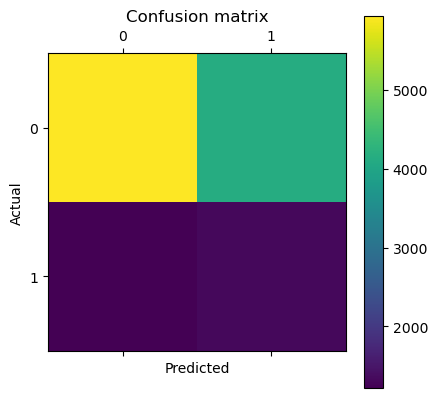

In [12]:
# Create Decision Tree classifer object
treeclf = tree.DecisionTreeClassifier()

# Run 5-fold CV and print results
cv_scores = cross_val_score(treeclf, X_train, y_train, cv=5)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

# Train Decision Tree Classifer
treeclf = treeclf.fit(X_train, y_train)

# Predict response for test and train sets
y_pred_test = treeclf.predict(X_test)

# Calculate and print ROC AUC score on test set
y_pred_proba = treeclf.predict_proba(X_test)[:,1] # necessary for ROC-AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print("Test ROC AUC Score:", auc_score)

# Classification Reports
print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test, y_pred_test))
y_pred_train = treeclf.predict(X_train)
print('-'*55)
print('Classification Report on Train Set:')
print('-'*55)
print(classification_report(y_train, y_pred_train))
print('-'*55)

# Create and plot confusion matrix
treecm = confusion_matrix(y_test, y_pred_test)
print(treecm)
plt.matshow(treecm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Plotting Feature Importances:**

The feature importances below may indicate overfitting. Pruning the tree may help in reducing overfitting.

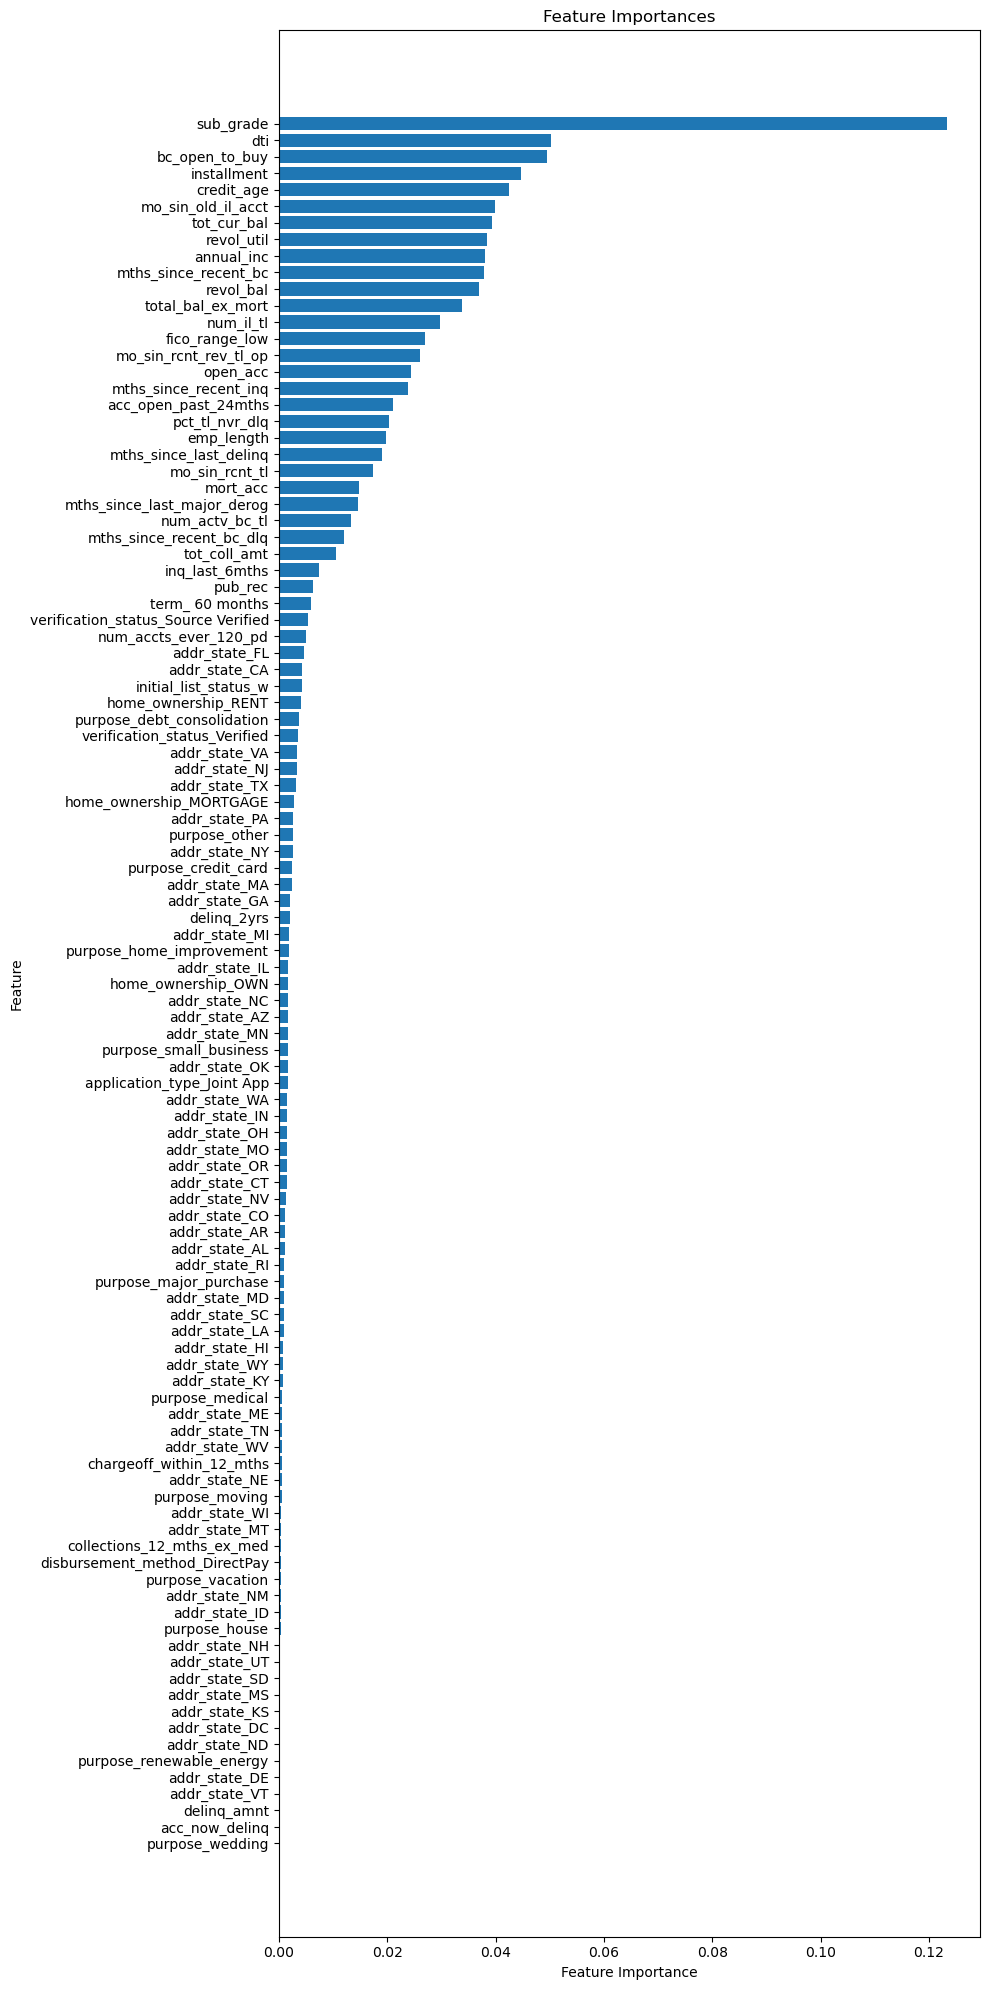

In [13]:
# Feature importances
def plot_feature_importances(model, feature_names):
    # Sort the features by their importance
    importances = model.feature_importances_
    indices = np.argsort(importances)

    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]

    # Create plot
    plt.figure(figsize=(10, 20))
    plt.title("Feature Importances")
    plt.barh(range(len(names)), importances[indices], align='center')
    plt.yticks(range(len(names)), names)
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    
    return names

importances = plot_feature_importances(treeclf, X.columns)

**Sampling & Normalizing Top 80 Features:**

This is around where the feature importances reach near 0 on the plot.

In [14]:
top_features = importances[:80]
X_top = X[top_features]
y_top = y

splitter=StratifiedShuffleSplit(n_splits=1, random_state=12, test_size=0.20)
for train,test in splitter.split(X_top, y_top):
    X_train_top = X_top.iloc[train]
    y_train_top = y_top.iloc[train]
    X_test_top = X_top.iloc[test]
    y_test_top = y_top.iloc[test]
    
undersample = RandomUnderSampler(random_state=12)
X_train_top, y_train_top = undersample.fit_resample(X_train_top, y_train_top)

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train_top)

# Use the scaler to transfrom both training and test data sets
X_train_top = min_max_scaler.fit_transform(X_train_top)
X_test_top = min_max_scaler.fit_transform(X_test_top)

y_train_top = np.array(y_train_top).flatten()
y_test_top = np.array(y_test_top).flatten()

**Default Decision Tree Model Using Top 80 Features:**

From the results below it appears that the performance on the test set is slighly worse after pruning what appeared to be unimportant features. After testing with various subsets of the most important features (top 70, top 90, top 100...etc) it seems that using all the features yields the best performance.

Overall Accuracy on X-Val: 0.54 (+/- 0.01)
Test ROC AUC Score: 0.530199072325973
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.82      0.59      0.68     10083
        True       0.23      0.48      0.31      2542

    accuracy                           0.57     12625
   macro avg       0.52      0.53      0.50     12625
weighted avg       0.70      0.57      0.61     12625

-------------------------------------------------------
Classification Report on Train Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.88      0.96      0.92     10167
        True       0.95      0.88      0.91     10167

    accuracy                           0.92     20334
   macro avg       0.92      0.92      0.92     20334
weighted avg       0.92  

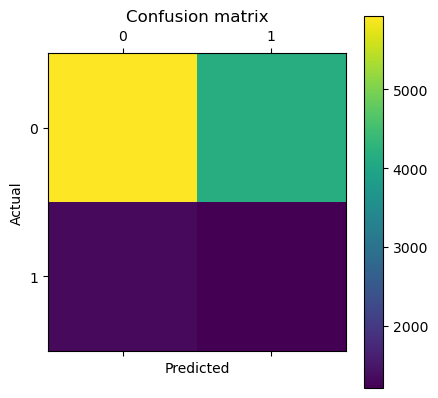

In [15]:
# Create Decision Tree classifer object
treeclf = tree.DecisionTreeClassifier()

# Run 5-fold CV and print results
cv_scores = cross_val_score(treeclf, X_train_top, y_train_top, cv=5)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

# Train Decision Tree Classifer
treeclf = treeclf.fit(X_train_top, y_train_top)

# Predict response for test and train sets
y_pred_test = treeclf.predict(X_test_top)

# Calculate and print ROC AUC score on test set
y_pred_proba = treeclf.predict_proba(X_test_top)[:,1] # necessary for ROC-AUC score
auc_score = roc_auc_score(y_test_top, y_pred_proba)
print("Test ROC AUC Score:", auc_score)

# Classification Reports
print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test_top, y_pred_test))
y_pred_train = treeclf.predict(X_train_top)
print('-'*55)
print('Classification Report on Train Set:')
print('-'*55)
print(classification_report(y_train_top, y_pred_train))
print('-'*55)

# Create and plot confusion matrix
treecm = confusion_matrix(y_test_top, y_pred_test)
print(treecm)
plt.matshow(treecm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Decision Tree Parameter Optimization Using Grid Search:**

In [135]:
# GridsearchCV using ROC AUC
scoring = {"AUC": "roc_auc"}
treeclf = tree.DecisionTreeClassifier(random_state=42)

param_dict = {
    'criterion': ['gini','entropy'],
    'max_depth': range(1,6),
    'min_samples_split':range(2, 1000, 50),
    'min_samples_leaf':range(1,1000,50)
}

gs = GridSearchCV(treeclf, 
                  param_grid=param_dict, 
                  verbose=1, 
                  scoring=scoring, 
                  refit="AUC", 
                  n_jobs=2, 
                  return_train_score=True,)

gs.fit(X_train, y_train)

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=2,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 1000, 50),
                         'min_samples_split': range(2, 1000, 50)},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy'}, verbose=1)

In [141]:
results = gs.cv_results_
gs.best_params_, gs.best_score_

({'criterion': 'entropy',
  'max_depth': 5,
  'min_samples_leaf': 401,
  'min_samples_split': 952},
 0.6940339130400013)

In [140]:
# GridsearchCV using PR AUC
scoring = {"PR_AUC": "average_precision"}
treeclf = tree.DecisionTreeClassifier(random_state=42)

param_dict = {
    'criterion': ['gini','entropy'],
    'max_depth': range(1,6),
    'min_samples_split':range(2, 1000, 50),
    'min_samples_leaf':range(1,1000,50)
}

gs_prauc = GridSearchCV(treeclf, 
                  param_grid=param_dict, 
                  verbose=1, 
                  scoring=scoring, 
                  refit="PR_AUC",
                  return_train_score=True,)

gs_prauc.fit(X_train, y_train)

Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 6),
                         'min_samples_leaf': range(1, 1000, 50),
                         'min_samples_split': range(2, 1000, 50)},
             refit='PR_AUC', return_train_score=True,
             scoring={'PR_AUC': 'average_precision'}, verbose=1)

In [148]:
results = gs_prauc.cv_results_
gs_prauc.best_params_, gs_prauc.best_score_

({'criterion': 'gini',
  'max_depth': 5,
  'min_samples_leaf': 401,
  'min_samples_split': 2},
 0.6666122148373169)

In [161]:
%%html
<! Left align table in following cell>
<style>
table {float:left}
</style>

**Train Model Using Best Params from Grid Search:**

Both best params from gridsearches using AUROC and AUPR scores yield practically identical results. Neither performed very well:

|                         | ROC AUC | PR AUC |
|-------------------------|---------|--------|
| Avg. Accuracy on X-Val: | 0.63    | 0.63   |
| Test ROC AUC            | 0.679   | 0.679  |
| Test PR AUC             | 0.326   | 0.327  |
| Test Accuracy           | 0.60    | 0.60   |
| Test Precision          | 0.29    | 0.29   |
| Test Recall             | 0.69    | 0.69   |

Overall Accuracy on X-Val: 0.63 (+/- 0.01)
Test ROC AUC Score: 0.6796497801528196
Test PR AUC Score: 0.3268546185342954
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.88      0.58      0.70     10083
        True       0.29      0.69      0.41      2542

    accuracy                           0.60     12625
   macro avg       0.59      0.63      0.55     12625
weighted avg       0.76      0.60      0.64     12625

-------------------------------------------------------
Classification Report on Train Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.67      0.58      0.62     10167
        True       0.63      0.71      0.67     10167

    accuracy                           0.64     20334
   macro avg       0.65      0.64      0

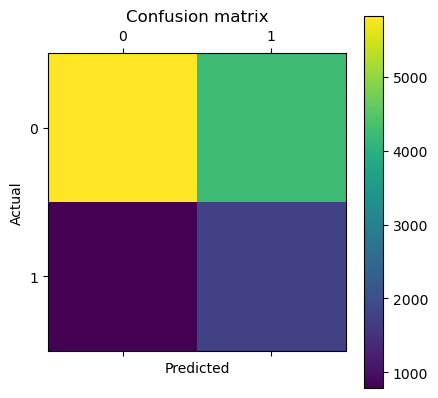

In [16]:
# Create Decision Tree classifer object
treeclf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=401, min_samples_split=952)

# Run 5-fold CV and print results
cv_scores = cross_val_score(treeclf, X_train, y_train, cv=5)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

# Train Decision Tree Classifer
treeclf = treeclf.fit(X_train, y_train)

# Predict response for test and train sets
y_pred_test = treeclf.predict(X_test)

# Calculate and print AUROC and AUPR on test set
y_pred_proba = treeclf.predict_proba(X_test)[:,1] # necessary for ROC-AUC score
auroc_score = roc_auc_score(y_test, y_pred_proba)
aupr_score = average_precision_score(y_test, y_pred_proba)
print("Test ROC AUC Score:", auroc_score)
print("Test PR AUC Score:", aupr_score)

# Classification Reports
print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test, y_pred_test))
y_pred_train = treeclf.predict(X_train)
print('-'*55)
print('Classification Report on Train Set:')
print('-'*55)
print(classification_report(y_train, y_pred_train))
print('-'*55)

# Create and plot confusion matrix
treecm = confusion_matrix(y_test, y_pred_test)
print(treecm)
plt.matshow(treecm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### K-Nearest-Neighbor:

**Creating Basic Model Using Balanced Data & n=5:**

In [17]:
n_neighbors = 5

knnclf = neighbors.KNeighborsClassifier(n_neighbors)

# Run 5-fold CV and print results
cv_scores = cross_val_score(knnclf, X_train, y_train, cv=5)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

knnclf.fit(X_train, y_train)

y_pred_test = knnclf.predict(X_test)

# Calculate and print AUROC and AUPR on test set
y_pred_proba = knnclf.predict_proba(X_test)[:,1] # necessary for AUC scores
auroc_score = roc_auc_score(y_test, y_pred_proba)
aupr_score = average_precision_score(y_test, y_pred_proba)
print("Test ROC AUC Score:", auroc_score)
print("Test PR AUC Score:", aupr_score)

print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test, y_pred_test))

y_pred_train = knnclf.predict(X_train)
print('-'*55)
print('Classification Report on Training Set:')
print('-'*55)
print(classification_report(y_train, y_pred_train))

Overall Accuracy on X-Val: 0.57 (+/- 0.01)
Test ROC AUC Score: 0.5865485042206336
Test PR AUC Score: 0.2447782355487253
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.83      0.58      0.68     10083
        True       0.25      0.55      0.34      2542

    accuracy                           0.57     12625
   macro avg       0.54      0.56      0.51     12625
weighted avg       0.72      0.57      0.61     12625

-------------------------------------------------------
Classification Report on Training Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.72      0.73      0.73     10167
        True       0.73      0.72      0.72     10167

    accuracy                           0.72     20334
   macro avg       0.72      0.72    

**Training Model Using OG Imbalanced Data:**

In [18]:
n_neighbors = 5

knnclf = neighbors.KNeighborsClassifier(n_neighbors)

# Run 5-fold CV and print results
cv_scores = cross_val_score(knnclf, X_train_imbal, y_train_imbal, cv=5)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

knnclf.fit(X_train_imbal, y_train_imbal)

y_pred_test = knnclf.predict(X_test)

# Calculate and print AUROC and AUPR on test set
y_pred_proba = knnclf.predict_proba(X_test)[:,1] # necessary for AUC scores
auroc_score = roc_auc_score(y_test, y_pred_proba)
aupr_score = average_precision_score(y_test, y_pred_proba)
print("Test ROC AUC Score:", auroc_score)
print("Test PR AUC Score:", aupr_score)

print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test, y_pred_test))

y_pred_train = knnclf.predict(X_train_imbal)
print('-'*55)
print('Classification Report on Training Set:')
print('-'*55)
print(classification_report(y_train_imbal, y_pred_train))

Overall Accuracy on X-Val: 0.77 (+/- 0.00)
Test ROC AUC Score: 0.5732524687111139
Test PR AUC Score: 0.24147795753242499
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.81      0.93      0.87     10083
        True       0.32      0.12      0.18      2542

    accuracy                           0.77     12625
   macro avg       0.56      0.53      0.52     12625
weighted avg       0.71      0.77      0.73     12625

-------------------------------------------------------
Classification Report on Training Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.84      0.97      0.90     40331
        True       0.67      0.26      0.38     10167

    accuracy                           0.83     50498
   macro avg       0.75      0.61   

**Using Cross Validation to Get the Best Value of K:**

In [168]:
k_values = [i for i in range (1,150)]
au_roc = []
au_pr = []
acc = []
precisions = []
recalls = []

for k in k_values:
    
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    auroc = cross_val_score(knn, X_train, y_train, cv=5, scoring="roc_auc")
    
    aupr = cross_val_score(knn, X_train, y_train, cv=5, scoring="average_precision")
    
    accuracy = cross_val_score(knn, X_train, y_train, cv=5, scoring="accuracy")

    precision = cross_val_score(knn, X_train, y_train, cv=5, scoring="precision")
    
    recall = cross_val_score(knn, X_train, y_train, cv=5, scoring="recall")
    
    au_roc.append(np.mean(auroc))
    au_pr.append(np.mean(aupr))
    acc.append(np.mean(accuracy))
    precisions.append(np.mean(precision))
    recalls.append(np.mean(recall))

**Plotting the Performance Metrics for Each K-value:**

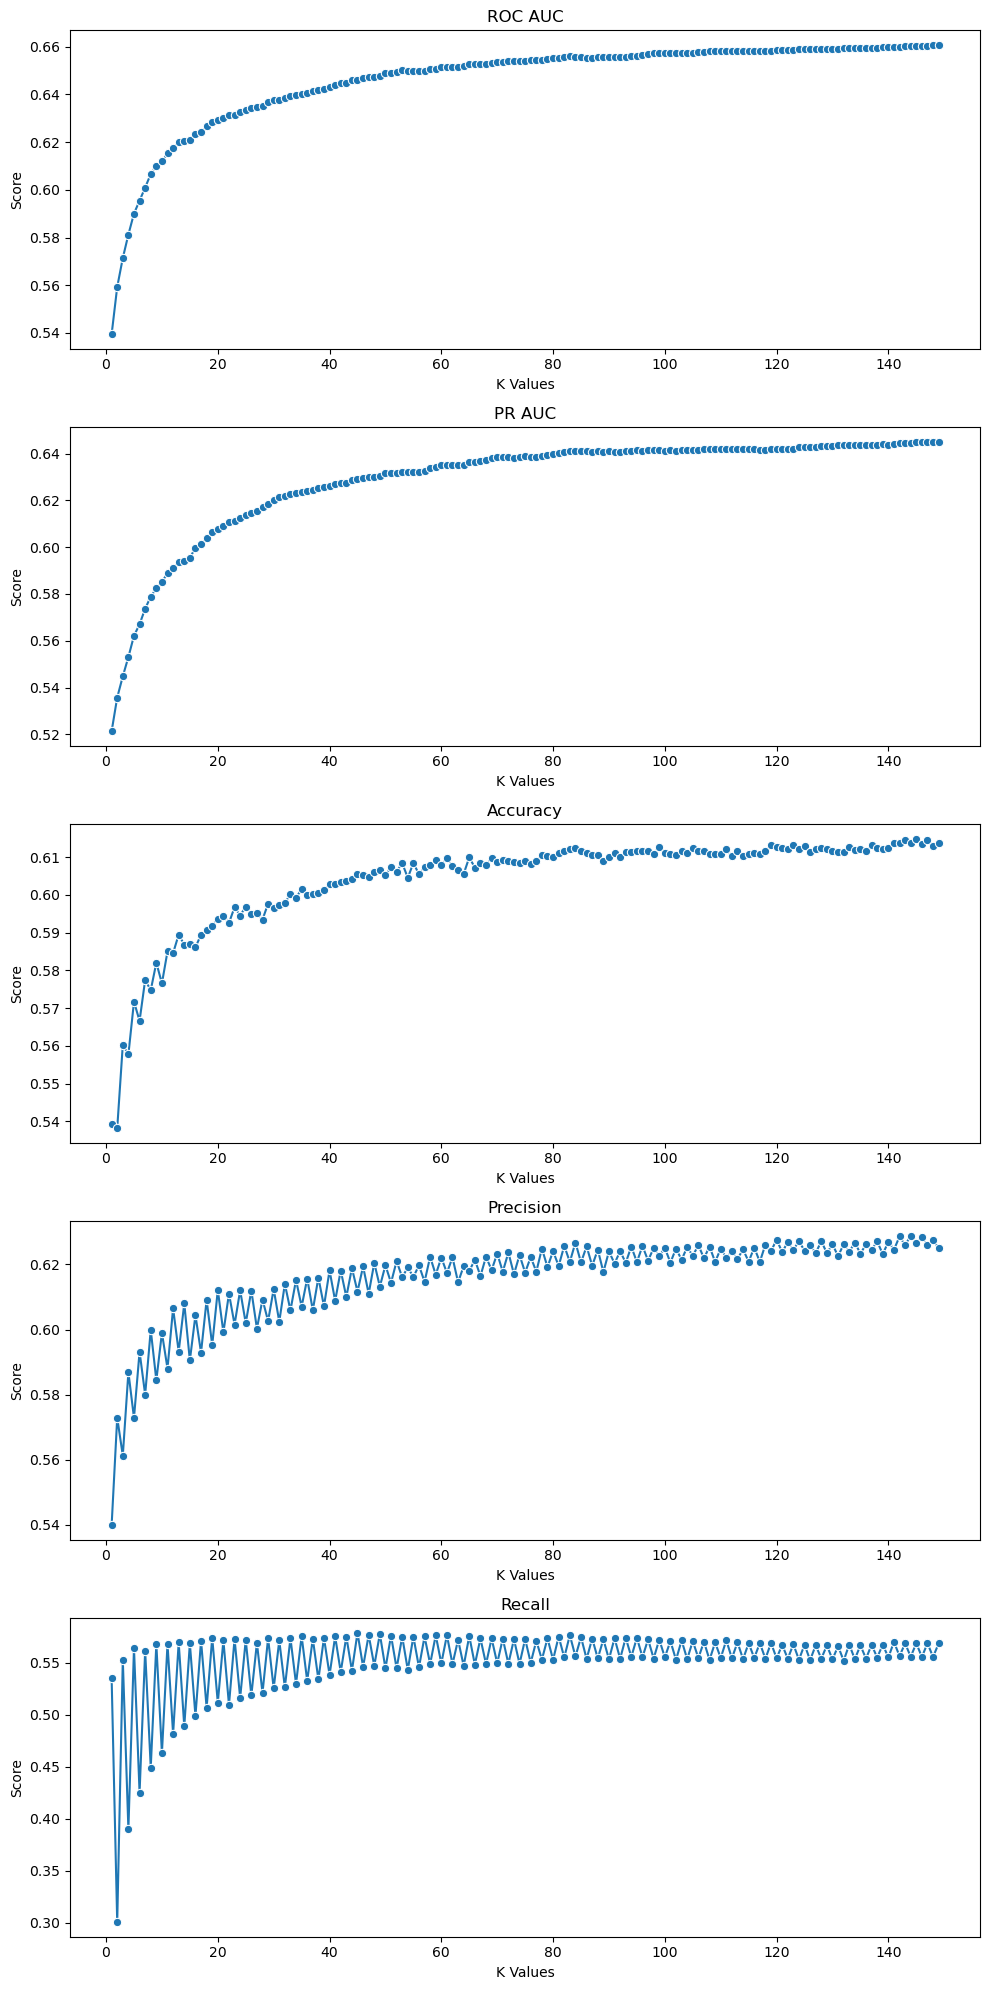

In [199]:
# Define the scores with their respective names
scores_with_names = [
    ('ROC AUC', au_roc),
    ('PR AUC', au_pr),
    ('Accuracy', acc),
    ('Precision', precisions),
    ('Recall', recalls)
]

# Create a 5x1 grid of subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Create each subplot
for (name, score), ax in zip(scores_with_names, axs.ravel()):
    sns.lineplot(x=k_values, y=score, marker='o', ax=ax)
    ax.set_xlabel("K Values")
    ax.set_ylabel('Score')
    ax.set_title(name)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()

**Building Model with Best K-value for PR AUC:**

In [201]:
best_index = np.argmax(au_pr)
best_k = k_values[best_index]

knnclf = neighbors.KNeighborsClassifier(n_neighbors=best_k)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

knnclf.fit(X_train, y_train)

y_pred_test = knnclf.predict(X_test)

# Calculate and print AUROC and AUPR on test set
y_pred_proba = knnclf.predict_proba(X_test)[:,1] # necessary for AUC scores
auroc_score = roc_auc_score(y_test, y_pred_proba)
aupr_score = average_precision_score(y_test, y_pred_proba)
print("Test ROC AUC Score:", auroc_score)
print("Test PR AUC Score:", aupr_score)

print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test, y_pred_test))

y_pred_train = knnclf.predict(X_train)
print('-'*55)
print('Classification Report on Training Set:')
print('-'*55)
print(classification_report(y_train, y_pred_train))

Overall Accuracy on X-Val: 0.77 (+/- 0.00)
Test ROC AUC Score: 0.6618543664297579
Test PR AUC Score: 0.32261292135191316
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.86      0.67      0.75     10083
        True       0.30      0.56      0.39      2542

    accuracy                           0.65     12625
   macro avg       0.58      0.62      0.57     12625
weighted avg       0.75      0.65      0.68     12625

-------------------------------------------------------
Classification Report on Training Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.61      0.68      0.64     10167
        True       0.64      0.57      0.60     10167

    accuracy                           0.62     20334
   macro avg       0.62      0.62   

### Ensemble Classifiers: Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [20]:
def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confussion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred),"\n")
      
    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

**RandomizedSearchCV:**

With so many hyperparameters and ranges of values to try, I will first used a randomized gridsearch to help narrow down the optimal ranges for my hyperparameters.

In [ ]:
# Create the base model to tune
rfclf = RandomForestClassifier(random_state=42)

param_dict = { 
    'criterion' :['gini', 'entropy'],
    'max_depth' : range(1,100,2),
    'min_samples_leaf':range(1,1000,50),
    'min_samples_split':range(2, 1000, 50),
    'n_estimators': range(1, 1000, 50),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

rs_prauc = RandomizedSearchCV(rfclf,
                  random_state=42,
                  param_distributions=param_dict, 
                  verbose=1, 
                  scoring="average_precision",
                  n_iter = 1000,
                  n_jobs = -1,
                  return_train_score=True,)

rs_prauc.fit(X_train, y_train)

In [38]:
rs_prauc.best_params_

{'n_estimators': 501,
 'min_samples_split': 102,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 59,
 'criterion': 'entropy',
 'bootstrap': True}

**Build Model with Best Param Values from Randomized Search:**

In [39]:
rfclf = RandomForestClassifier(n_estimators=501, min_samples_split=102, min_samples_leaf=1, max_features='sqrt', max_depth=59, criterion='entropy', bootstrap=True)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

rfclf.fit(X_train, y_train)

y_pred_test = rfclf.predict(X_test)

# Calculate and print AUROC and AUPR on test set
y_pred_proba = rfclf.predict_proba(X_test)[:,1] # necessary for AUC scores
auroc_score = roc_auc_score(y_test, y_pred_proba)
aupr_score = average_precision_score(y_test, y_pred_proba)
print("Test ROC AUC Score:", auroc_score)
print("Test PR AUC Score:", aupr_score)

print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test, y_pred_test))

y_pred_train = rfclf.predict(X_train)
print('-'*55)
print('Classification Report on Training Set:')
print('-'*55)
print(classification_report(y_train, y_pred_train))

Overall Accuracy on X-Val: 0.77 (+/- 0.00)
Test ROC AUC Score: 0.7051121638473057
Test PR AUC Score: 0.369545374808142
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.87      0.72      0.79     10083
        True       0.34      0.57      0.43      2542

    accuracy                           0.69     12625
   macro avg       0.61      0.65      0.61     12625
weighted avg       0.76      0.69      0.72     12625

-------------------------------------------------------
Classification Report on Training Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.78      0.74      0.76     10167
        True       0.75      0.79      0.77     10167

    accuracy                           0.76     20334
   macro avg       0.76      0.76     

**GridSearchCV with Narrowed Ranges using values from Randomized Search:**

In [44]:
# Create the base model to tune
rfclf = RandomForestClassifier(random_state=42)

param_dict = { 
    'criterion' :['entropy'],
    'max_depth' : range(50,100,2),
    'min_samples_leaf':range(1,2,1),
    'min_samples_split':range(2, 200, 20),
    'n_estimators': range(400, 600, 50),
    'max_features': ['sqrt'],
    'bootstrap': [True]
}

gs_prauc = GridSearchCV(rfclf, 
                  param_grid=param_dict, 
                  verbose=1, 
                  scoring="average_precision", 
                  n_jobs = -1,
                  return_train_score=True,)

gs_prauc.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['entropy'],
                         'max_depth': range(50, 100, 2),
                         'max_features': ['sqrt'],
                         'min_samples_leaf': range(1, 2),
                         'min_samples_split': range(2, 200, 20),
                         'n_estimators': range(400, 600, 50)},
             return_train_score=True, scoring='average_precision', verbose=1)

In [45]:
gs_prauc.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 122,
 'n_estimators': 550}

In [46]:
rfclf = RandomForestClassifier(n_estimators=550, min_samples_split=122, min_samples_leaf=1, max_features='sqrt', max_depth=50, criterion='entropy', bootstrap=True)
print("Overall Accuracy on X-Val: %0.2f (+/- %0.2f)" % (cv_scores.mean(), cv_scores.std() * 2))

rfclf.fit(X_train, y_train)

y_pred_test = rfclf.predict(X_test)

# Calculate and print AUROC and AUPR on test set
y_pred_proba = rfclf.predict_proba(X_test)[:,1] # necessary for AUC scores
auroc_score = roc_auc_score(y_test, y_pred_proba)
aupr_score = average_precision_score(y_test, y_pred_proba)
print("Test ROC AUC Score:", auroc_score)
print("Test PR AUC Score:", aupr_score)

print('-'*55)
print('Classification Report on Test Set:')
print('-'*55)
print(classification_report(y_test, y_pred_test))

y_pred_train = rfclf.predict(X_train)
print('-'*55)
print('Classification Report on Training Set:')
print('-'*55)
print(classification_report(y_train, y_pred_train))

Overall Accuracy on X-Val: 0.77 (+/- 0.00)
Test ROC AUC Score: 0.7056679364578483
Test PR AUC Score: 0.3682785361046006
-------------------------------------------------------
Classification Report on Test Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.87      0.72      0.79     10083
        True       0.34      0.57      0.43      2542

    accuracy                           0.69     12625
   macro avg       0.60      0.64      0.61     12625
weighted avg       0.76      0.69      0.71     12625

-------------------------------------------------------
Classification Report on Training Set:
-------------------------------------------------------
              precision    recall  f1-score   support

       False       0.76      0.72      0.74     10167
        True       0.74      0.78      0.76     10167

    accuracy                           0.75     20334
   macro avg       0.75      0.75    

### Model Performances:

|                            | Decision Trees | KNN            | Random Forest |
|----------------------------|----------------|----------------|---------------|
| **Avg. Accuracy on X-Val** | 0.63           | 0.77           | 0.77          |
| **Test ROC AUC**           | 0.679          | 0.662          | 0.706         |
| **Test PR AUC**            | 0.327          | 0.323          | 0.368         |
| **Test Accuracy**          | 0.60           | 0.65           | 0.69          |
| **Test Precision**         | 0.29           | 0.30           | 0.34          |
| **Test Recall**            | 0.69           | 0.56           | 0.57          |

**Results:**